In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# assortment of relevant BED files with the features of interest ...
feature_of_interest = "rad21_merged.bed"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"]
)
df = df.sort_values(["chrom","start"])
df = df[df["chrom"].isin(autosomal_chroms)]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


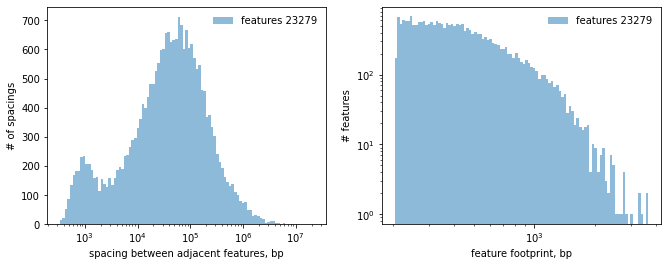

In [6]:
# calculate "spacing" between adjacent features,
# assuming coordinates are sorted !
plot_spacing_footprint_distros({k:df for k in ['features']})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

number of candidate features before and after merging: 23279 -> 21968


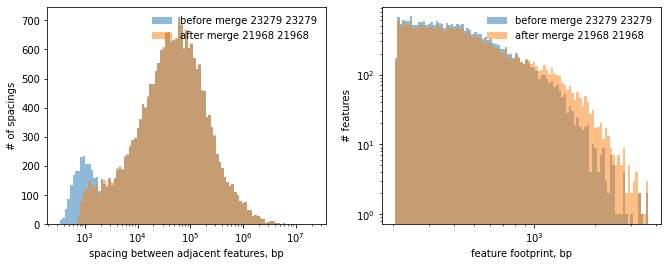

In [7]:
merge_radius = 500
df_merged = bf.merge(df, min_dist=merge_radius)

plot_spacing_footprint_distros({
    f"before merge {len(df)}":df,
    f"after merge {len(df_merged)}":df_merged,
})

print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [8]:
bw_fnames = OrderedDict()
bw_fnames["G4a_r1"] = "GSM2876090_B_REP1.SLX-12319.K562_asynch_a_701_504.clean.bw"
bw_fnames["G4c_r1"] = "GSM2876091_B_REP1.SLX-12319.K562_asynch_c_703_504.clean.bw"
bw_fnames["G4c_r2"] = "GSM2876093_B_REP2.SLX-12320.K562_P9_Async_c_701_503.rmdup.clean.bw"
bw_fnames["G4b_r2"] = "GSM2876094_B_REP2.SLX-12320.K562_P9_Async_b_701_502.rmdup.clean.bw"
bw_fnames["G4a_r2"] = "GSM2876095_B_REP2.SLX-12320.K562_P9_Async_a_701_517.rmdup.clean.bw"
# set some stackups paramters - plotting and stacking ....
titles = list(bw_fnames.keys())

binsizes = {}
for s in bw_fnames:
    binsizes[s] = 100

flanks = {}
for s in bw_fnames:
    flanks[s] = 5_000

cmps = {}
for s in bw_fnames:
    cmps[s] = cmap3
    
norms = {}
for s in bw_fnames:
    norms[s] = None


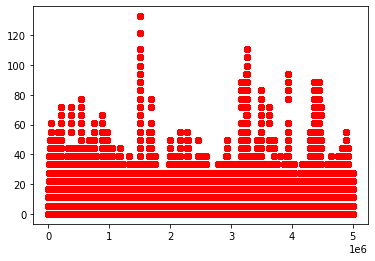

In [11]:
# just trying to how the signal even looks like - what's the range for the colorscale ....
G4_slice = bbi.fetch(
    bw_fnames["G4a_r1"],
    "chr1",
    110_000_000,
    115_000_000,
    bins=-1,
    missing=0.0,
    oob=np.nan,
    summary='mean',
)

plt.plot(G4_slice,"ro")

### next is computation heavy step - stackups using bbi ...

In [12]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s] )

stacking up G4a_r1 ...
CPU times: user 3.61 s, sys: 140 ms, total: 3.75 s
Wall time: 3.75 s
stacking up G4c_r1 ...
CPU times: user 3.63 s, sys: 132 ms, total: 3.77 s
Wall time: 3.77 s
stacking up G4c_r2 ...
CPU times: user 3.85 s, sys: 200 ms, total: 4.05 s
Wall time: 4.05 s
stacking up G4b_r2 ...
CPU times: user 4.03 s, sys: 221 ms, total: 4.25 s
Wall time: 4.27 s
stacking up G4a_r2 ...
CPU times: user 4.17 s, sys: 128 ms, total: 4.3 s
Wall time: 4.28 s


### it's amazing how much you can do with a stack up !

we can flip certain rows !

_beware_ that we are reordering index this way, and we also might loos some rows from a stackup because of NaNs

In [13]:
length, width = stackups['G4a_r1'].shape
center_bin = int(width/2)
stackups['G4_mean'] = np.nanmean(stackups['G4a_r1'][:,center_bin-3:center_bin+3],axis=1)
initial_index = np.arange( len(stackups['G4_mean']) )
ks = [('G4_mean', "sort", 1, False)]
_, jjj = recursive_data_ordering( ks, initial_index, stackups, verbose=True)


sorting 21968 elements of G4_mean into 1 groups ...


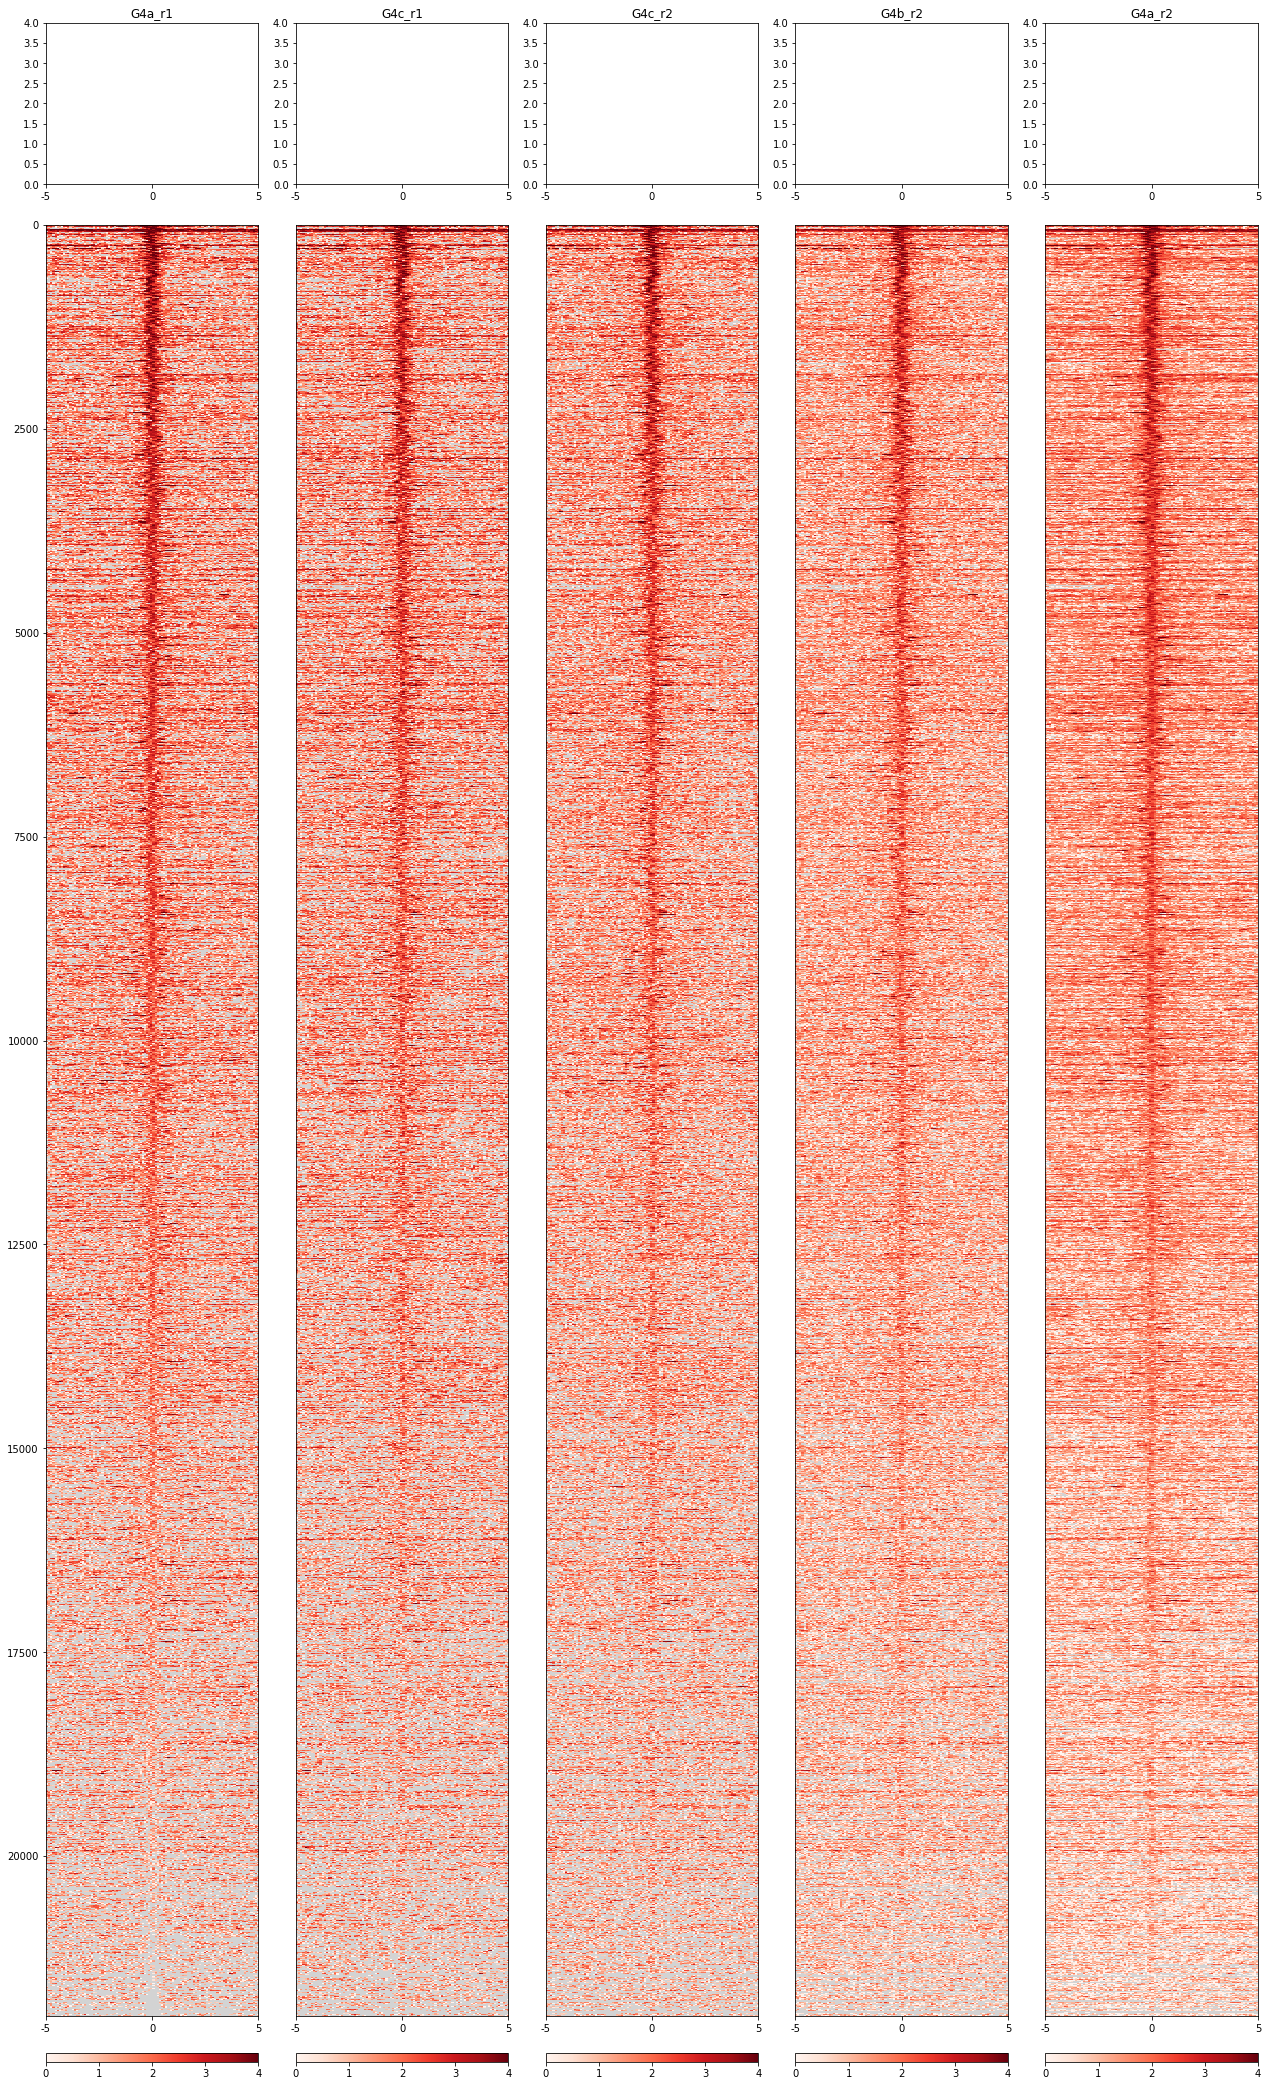

In [15]:
limss = {}
for s in bw_fnames:
    limss[s] = (0,4)
    
hmss = [ np.log(stackups[_k][jjj]) for _k in bw_fnames ]
_limss = [ limss[_k] for _k in bw_fnames ]
_cmps = [ cmps[_k] for _k in bw_fnames ]
_binsizes = [ binsizes[_k] for _k in bw_fnames ]
_norms = [ norms[_k] for _k in bw_fnames ]

plot_stackups(None,hmss,titles,_limss,_cmps,_norms,_binsizes,fname="xxx.png",fillmissing=False,interpolation="nearest")